In [79]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose#seasonal_decompose decomposes time series data into trend, seasonal, and residual components
from dateutil.parser import parse#converts strings into datetime objects
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm_notebook
import sys
np.set_printoptions(threshold=sys.maxsize)
import csv
from itertools import product
from sklearn.metrics import mean_squared_error

In [80]:
data = []
with open('Month_Rain.csv', 'r') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        year = int(row[0])
        for month in range(1, 13):
            date = datetime.datetime(year, month, 1)
            rain = float(row[month])
            data.append([date, rain])

# Convert to DataFrame
data = pd.DataFrame(data, columns=['date', 'rain'])

# Convert the date column to datetime64[ns] type
data['date'] = pd.to_datetime(data['date'])

# Print the DataFrame
data

,date,rain
0,1901-01-01,34.7
1,1901-02-01,38.6
2,1901-03-01,17.8
3,1901-04-01,38.9
4,1901-05-01,50.6
...,...,...
1339,2012-08-01,262.4
1340,2012-09-01,193.5
1341,2012-10-01,58.7
1342,2012-11-01,30.7


In [81]:
data

,date,rain
0,1901-01-01,34.7
1,1901-02-01,38.6
2,1901-03-01,17.8
3,1901-04-01,38.9
4,1901-05-01,50.6
...,...,...
1339,2012-08-01,262.4
1340,2012-09-01,193.5
1341,2012-10-01,58.7
1342,2012-11-01,30.7


In [82]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1344 entries, 0 to 1343
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1344 non-null   datetime64[ns]
 1   rain    1344 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 21.1 KB


In [83]:
data['date'] = pd.to_datetime(data['date'])

In [84]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1344 entries, 0 to 1343
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1344 non-null   datetime64[ns]
 1   rain    1344 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 21.1 KB


In [85]:
data['year'] = data.date.dt.year

In [86]:
data['month'] = data.date.dt.month

In [87]:
data['day'] = data.date.dt.day

In [88]:
data

,date,rain,year,month,day
0,1901-01-01,34.7,1901,1,1
1,1901-02-01,38.6,1901,2,1
2,1901-03-01,17.8,1901,3,1
3,1901-04-01,38.9,1901,4,1
4,1901-05-01,50.6,1901,5,1
...,...,...,...,...,...
1339,2012-08-01,262.4,2012,8,1
1340,2012-09-01,193.5,2012,9,1
1341,2012-10-01,58.7,2012,10,1
1342,2012-11-01,30.7,2012,11,1


In [89]:
yearly_rain = data.groupby('year', as_index = False)['rain'].sum()
yearly_rain

,year,rain
0,1901,1030.8
1,1902,1038.4
2,1903,1195.8
3,1904,1025.2
4,1905,977.5
...,...,...
107,2008,1118.1
108,2009,953.8
109,2010,1215.6
110,2011,1116.3


In [90]:
# month_rain = data.groupby('year', as_index = False)['rain'].sum()
# yearly_rain

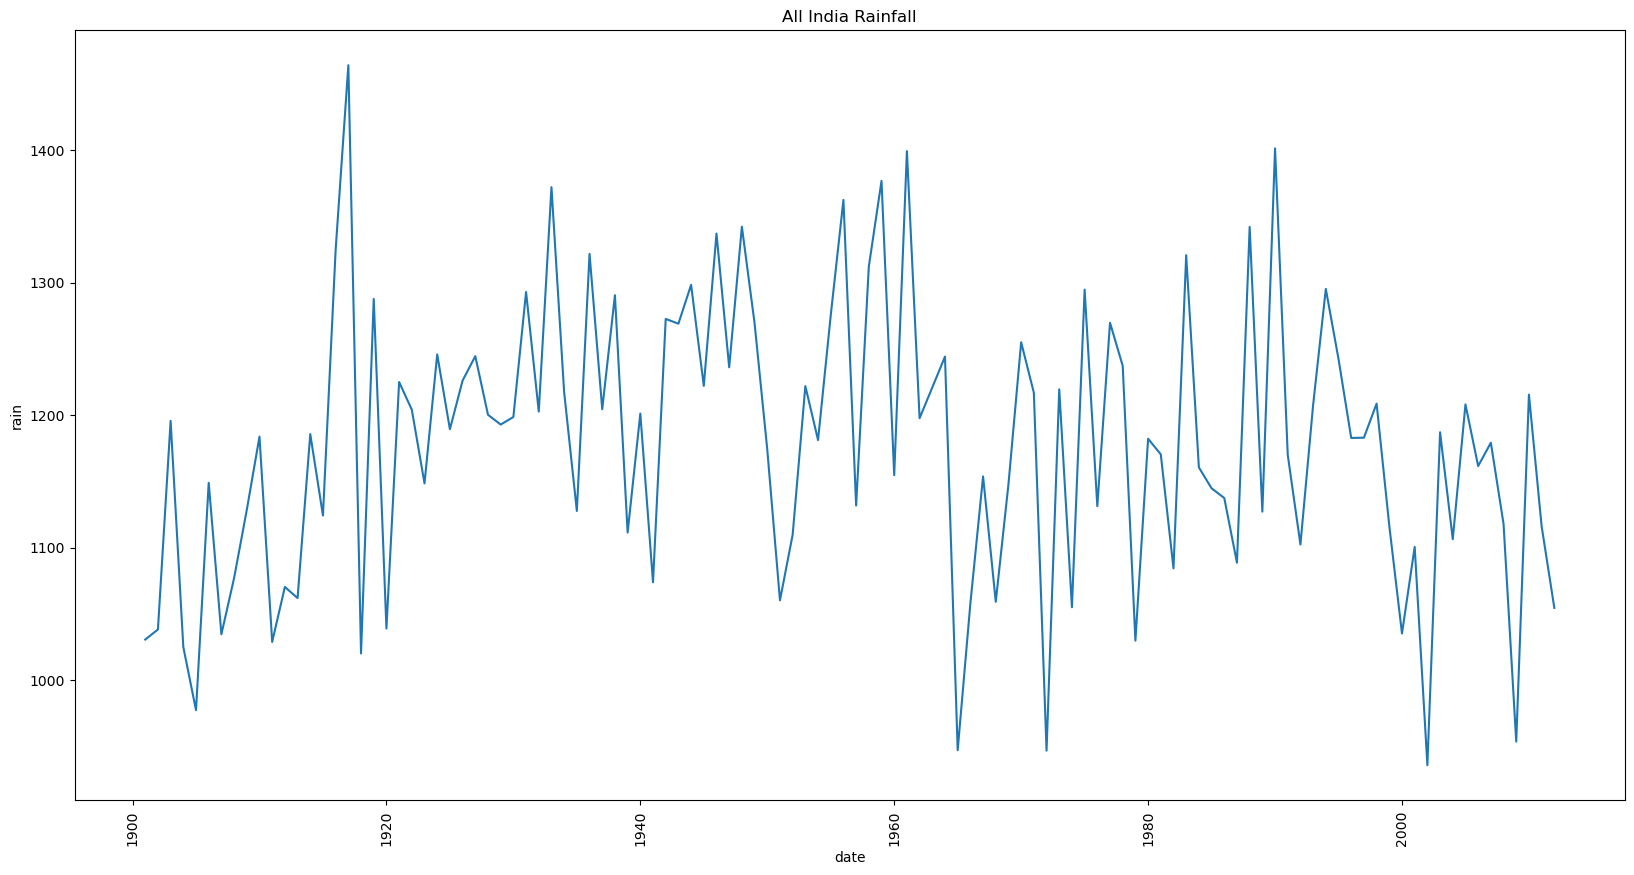

In [91]:
##Step 1 in Modelling. Plotting the data
plt.figure(figsize=(20, 10))
plt.plot(yearly_rain['year'], yearly_rain['rain'])

plt.title("All India Rainfall")
plt.xlabel("date")
plt.ylabel("rain")
plt.xticks(rotation = 90)
plt.show()

In [92]:
#Augmented Dickey Fuller test to test for stationarity
def adf(data):
    result = adfuller(data)
    print(result[0]) # Test Statistic
    print(result[1]) # p-value
    print(result[2]) # Lags Used
    print(result[3]) # Observations Used
    if result[1] <= 0.05:
        print("Reject null hypothesis, the given data is stationary.")
    else:
        print("Fail to reject null hypothesis, the given data is not stationary.")

In [93]:
adf(data['rain'].dropna())

-5.461380215789031
2.5141419453372184e-06
23
1320
Reject null hypothesis, the given data is stationary.


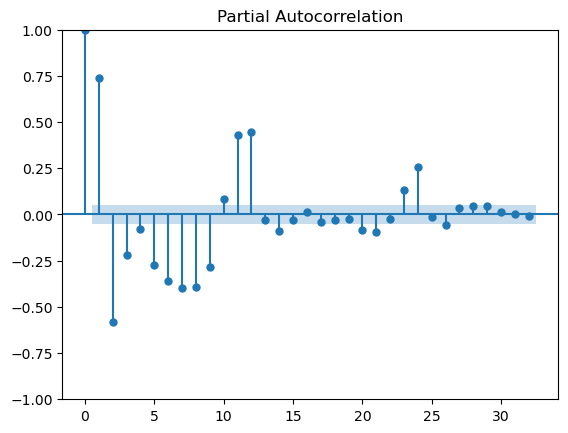

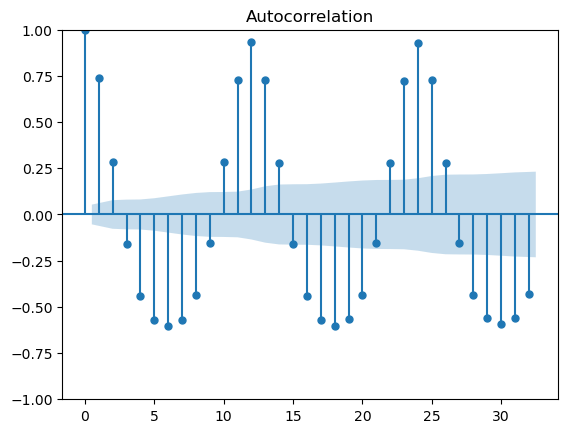

In [94]:
#Plotting the ACF and PACF charts.
plot_pacf(data['rain']);
plot_acf(data['rain']);

0 lags could simply mean autocorrelation is low and lagged values don't improve the model. The test still detects stationarity through other means without needing additional lag terms. The data may have noise-like behavior where past values have little impact on current values.

In [95]:
data['rain1'] = np.log(data['rain'])
data['rain1'] = data['rain1'].diff()

In [96]:
data

,date,rain,year,month,day,rain1
0,1901-01-01,34.7,1901,1,1,NaN
1,1901-02-01,38.6,1901,2,1,0.106513
2,1901-03-01,17.8,1901,3,1,-0.774054
3,1901-04-01,38.9,1901,4,1,0.781796
4,1901-05-01,50.6,1901,5,1,0.262957
...,...,...,...,...,...,...
1339,2012-08-01,262.4,2012,8,1,0.047609
1340,2012-09-01,193.5,2012,9,1,-0.304593
1341,2012-10-01,58.7,2012,10,1,-1.192838
1342,2012-11-01,30.7,2012,11,1,-0.648177


In [97]:
adf(data['rain1'].dropna())

-16.029427216533
6.080314352863364e-29
23
1319
Reject null hypothesis, the given data is stationary.


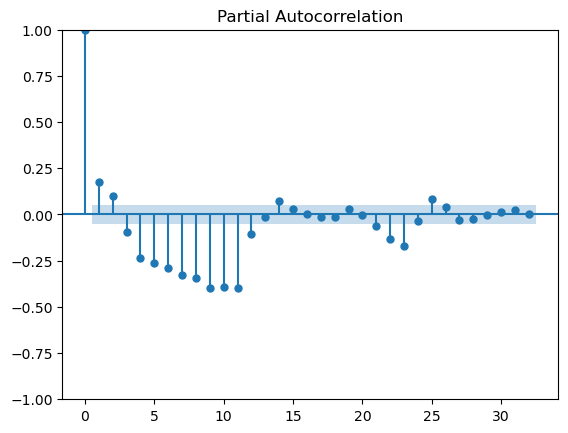

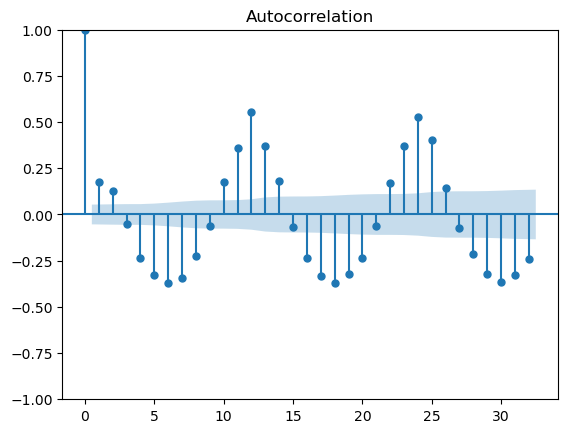

In [98]:
#Plotting the ACF and PACF charts.
plot_pacf(data['rain1'].dropna());
plot_acf(data['rain1'].dropna());

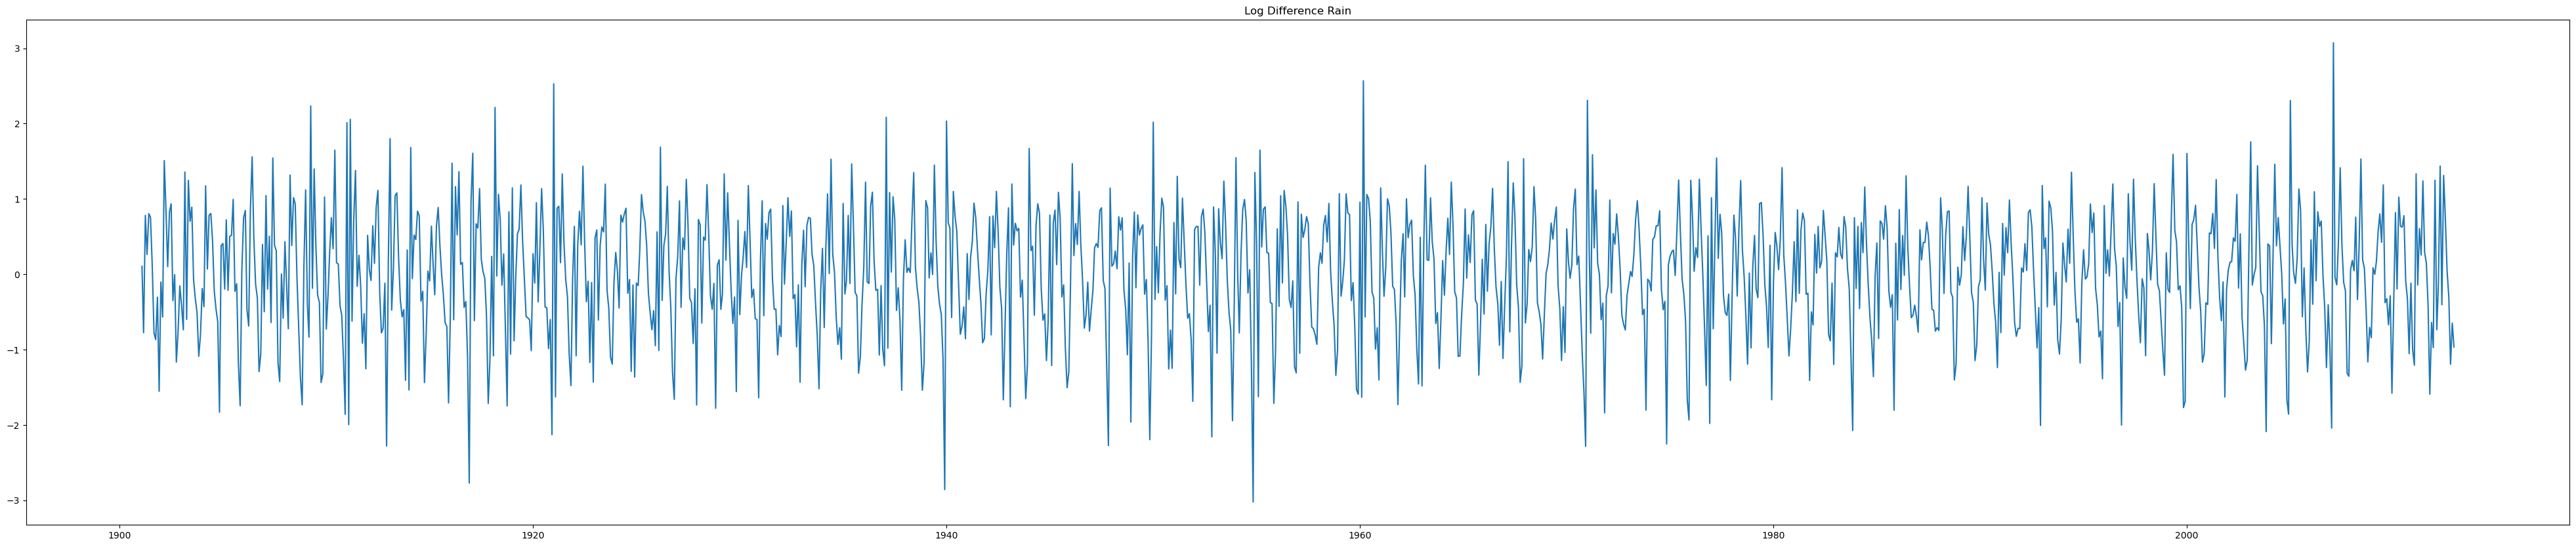

In [99]:
plt.figure(figsize=(50, 10))
plt.plot(data['date'],data['rain1'] )
plt.title("Log Difference Rain")
plt.show()

In [100]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [101]:
# #Model initialisation
# def optimize_ARIMA(data, order_list):
#     results = []
#     for order in order_list:
#         try:
#             model = SARIMAX(data, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s), simple_differencing=False).fit(disp=False)
#         except:
#             continue
#         aic = model.aic
#         results.append([order, model.aic])
#     result_df = pd.DataFrame(results)
#     result_df.columns = ['(p, d, q)', 'AIC']
#     result_df.columns = ['(p,q)x(P,Q)', 'AIC']

#     result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

#     return result_df

In [102]:
def optimize_ARIMA(data, order_list):

    results = []

    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(data, order=order, simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, model.aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [103]:
ps = range(0, 12, 1)
d = 1
qs = range(0, 9, 1)

# Create a list with all possible combination of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)

order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1, 1)
    each = tuple(each)
    order_list.append(each)

order_list[:10]

[(0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 1, 5),
 (0, 1, 6),
 (0, 1, 7),
 (0, 1, 8),
 (1, 1, 0)]

In [104]:
result_df = optimize_ARIMA(data['rain'], order_list)
result_df

  0%|          | 0/108 [00:00<?, ?it/s]

,"(p, d, q)",AIC
0,"(5, 1, 4)",50.326242
1,"(10, 1, 7)",12869.198305
2,"(10, 1, 8)",12882.445486
3,"(11, 1, 8)",12907.057595
4,"(9, 1, 7)",12914.150634
...,...,...
103,"(2, 1, 0)",14974.351886
104,"(1, 1, 1)",15001.518443
105,"(0, 1, 1)",15015.903884
106,"(1, 1, 0)",15018.151207


In [111]:
best_model = SARIMAX(data['rain'], order=(5, 1, 4), simple_differencing=False)
res = best_model.fit(disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                   rain   No. Observations:                 1344
Model:               SARIMAX(5, 1, 4)   Log Likelihood                 -15.163
Date:                Sat, 14 Oct 2023   AIC                             50.326
Time:                        23:33:17   BIC                            102.353
Sample:                             0   HQIC                            69.815
                               - 1344                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.000   5741.060      0.000       1.000       1.000
ar.L2          1.9998      0.000   9692.712      0.000       1.999       2.000
ar.L3         -1.9998      0.000  -9727.977      0.0

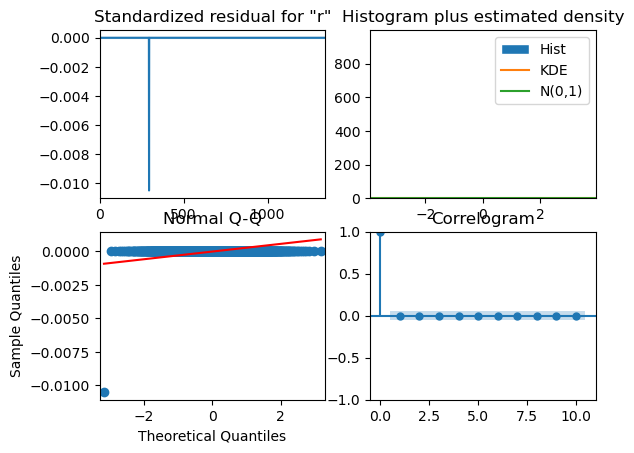

In [112]:
res.plot_diagnostics();

<Axes: >

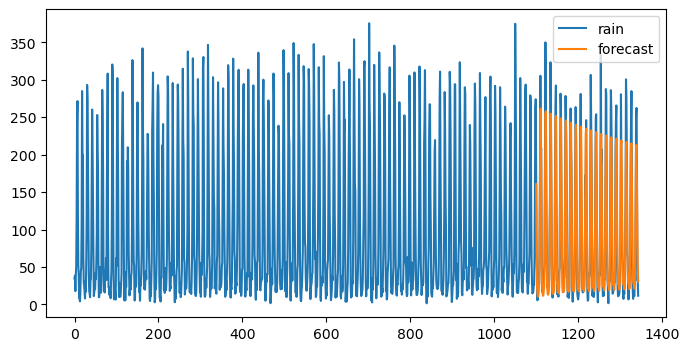

In [107]:
data['forecast']=res.predict(start=1100,end=1343,dynamic=True)
data[['rain','forecast']].plot(figsize=(8,4))

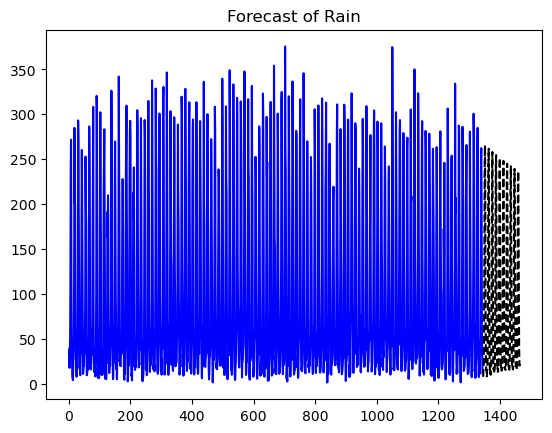

In [108]:
n_forecast = 120
predict = res.get_prediction(end=best_model.nobs + n_forecast)
idx = np.arange(len(predict.predicted_mean))

fig, ax = plt.subplots()
ax.plot(data['rain'], 'blue')
ax.plot(idx[-n_forecast:], predict.predicted_mean[-n_forecast:], 'k--')

ax.set(title = 'Forecast of Rain')
plt.show()

In [109]:
data['model'] = predict.predicted_mean
data.head()

,date,rain,year,month,day,rain1,forecast,model
0,1901-01-01,34.7,1901,1,1,NaN,NaN,0.000000
1,1901-02-01,38.6,1901,2,1,0.106513,NaN,34.726775
2,1901-03-01,17.8,1901,3,1,-0.774054,NaN,39.410174
3,1901-04-01,38.9,1901,4,1,0.781796,NaN,13.616643
4,1901-05-01,50.6,1901,5,1,0.262957,NaN,41.695530


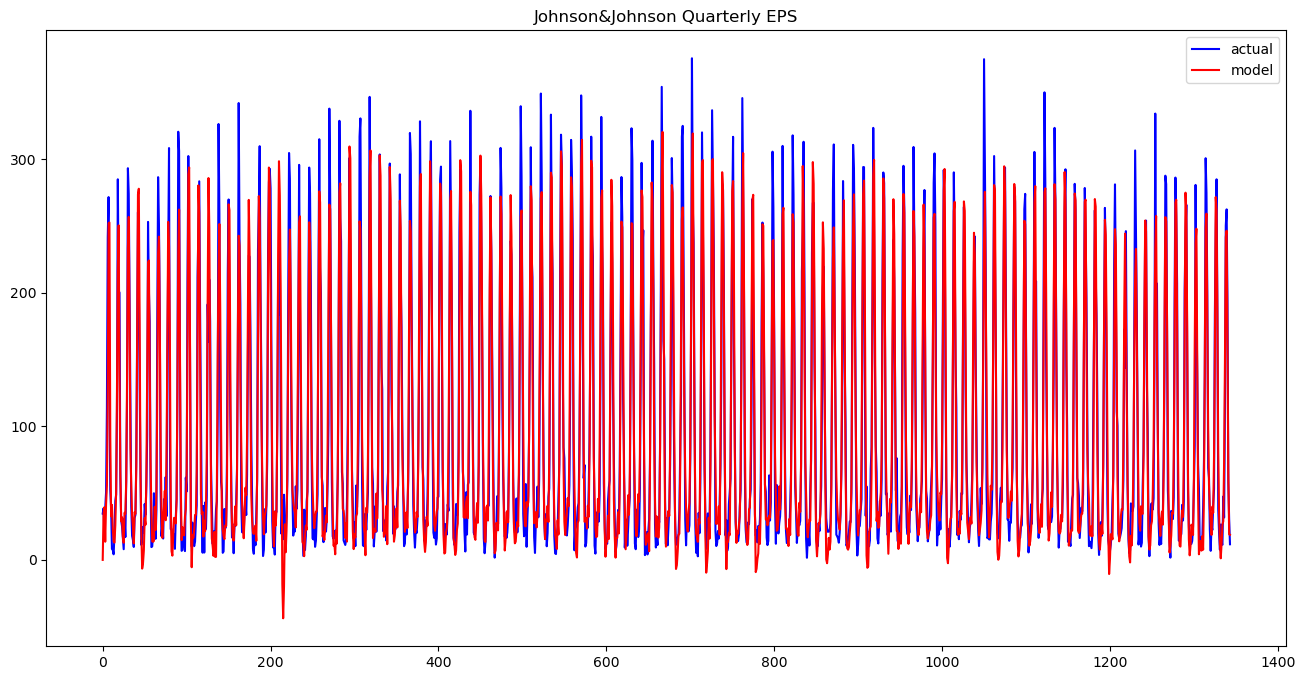

In [110]:
plt.figure(figsize=(16,8))
plt.plot(data['rain'], color='blue', label='actual')
plt.plot(data['model'], color='red', label='model')
plt.legend(loc='best')
plt.title('Johnson&Johnson Quarterly EPS')
plt.show()

In [118]:
mse = mean_squared_error(data['rain'], data['model'])
print(f'MSE: {mse}')

MSE: 827.2226288056204


In [121]:
best_model = SARIMAX(data['rain'], order=(10,1,7), seasonal_order=(10,1,7,12), simple_differencing=False)
res = best_model.fit(disp=False)
print(res.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                 rain   No. Observations:                 1344
Model:             SARIMAX(10, 1, 7)x(10, 1, 7, 12)   Log Likelihood               -6174.292
Date:                              Thu, 12 Oct 2023   AIC                          12418.584
Time:                                      18:06:16   BIC                          12600.363
Sample:                                           0   HQIC                         12486.708
                                             - 1344                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -3.4306      0.072    -47.495      0.000      -3.572      -3.289
ar.L2         -5.84

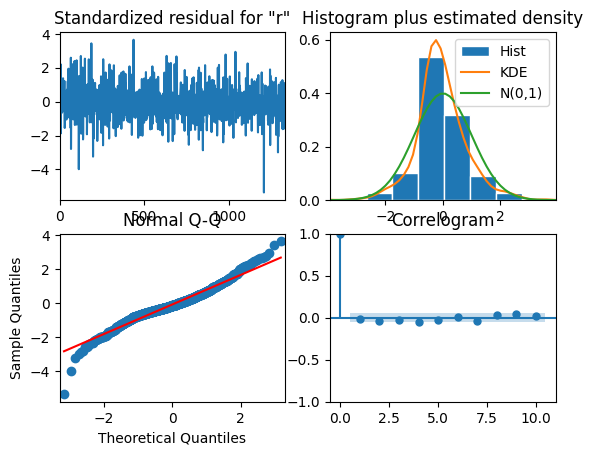

In [122]:
res.plot_diagnostics();

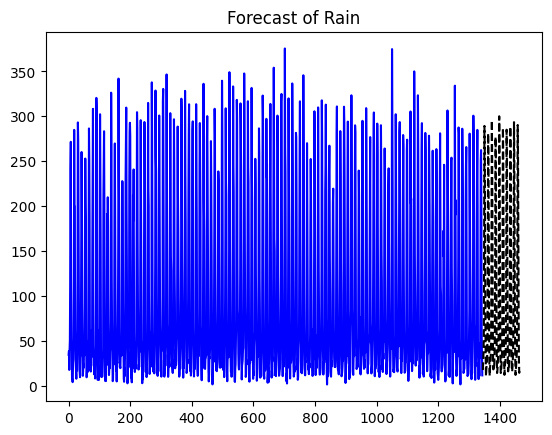

In [123]:
n_forecast = 120
predict = res.get_prediction(end=best_model.nobs + n_forecast)
idx = np.arange(len(predict.predicted_mean))

fig, ax = plt.subplots()
ax.plot(data['rain'], 'blue')
ax.plot(idx[-n_forecast:], predict.predicted_mean[-n_forecast:], 'k--')

ax.set(title = 'Forecast of Rain')
plt.show()

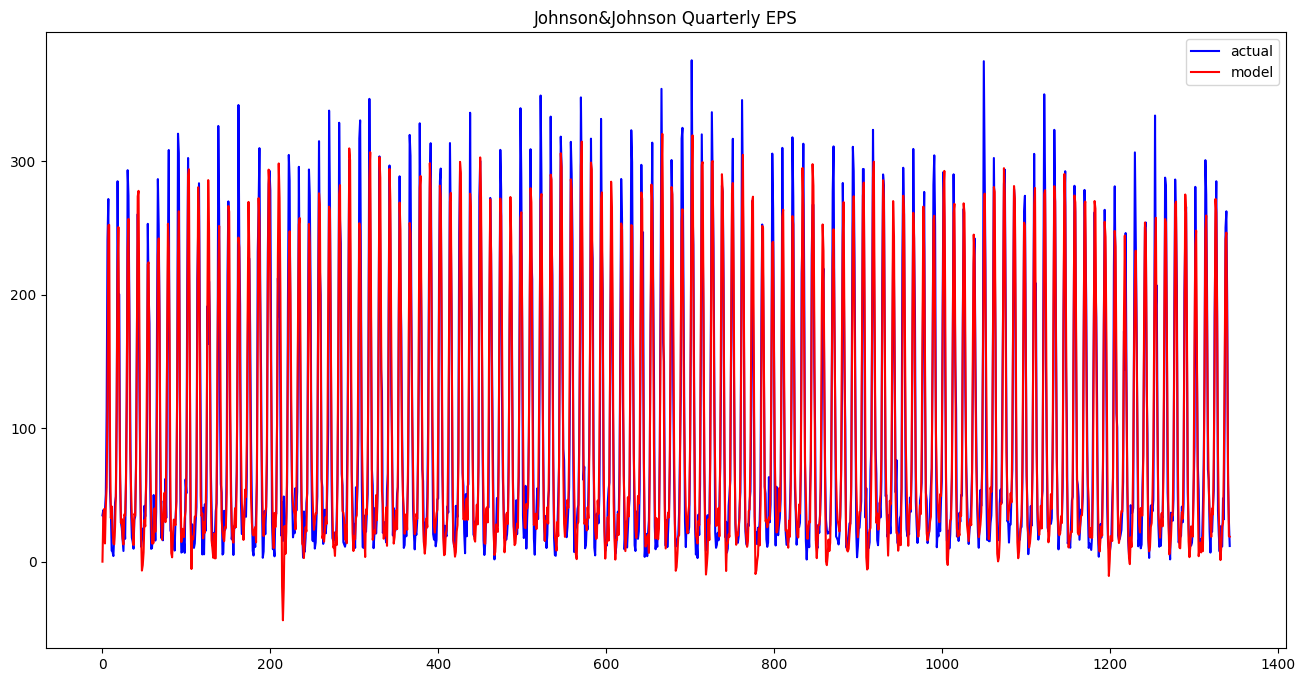

In [124]:
plt.figure(figsize=(16,8))
plt.plot(data['rain'], color='blue', label='actual')
plt.plot(data['model'], color='red', label='model')
plt.legend(loc='best')
plt.title('Johnson&Johnson Quarterly EPS')
plt.show()

In [125]:
mse = mean_squared_error(data['rain'], data['model'])
print(f'MSE: {mse}')

MSE: 827.2226288056204


In [14]:
data 

,date,rain,year,month,day
0,1901-01-01,34.7,1901,1,1
1,1901-02-01,38.6,1901,2,1
2,1901-03-01,17.8,1901,3,1
3,1901-04-01,38.9,1901,4,1
4,1901-05-01,50.6,1901,5,1
...,...,...,...,...,...
1339,2012-08-01,262.4,2012,8,1
1340,2012-09-01,193.5,2012,9,1
1341,2012-10-01,58.7,2012,10,1
1342,2012-11-01,30.7,2012,11,1


In [64]:
data=pd.DataFrame(data)

In [65]:
dum = pd.get_dummies(data['month'], dtype = int)
dum.columns = ['month-' + str(m) for m in range(1, 13)]

In [66]:
dum

,month-1,month-2,month-3,month-4,month-5,month-6,month-7,month-8,month-9,month-10,month-11,month-12
0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1339,0,0,0,0,0,0,0,1,0,0,0,0
1340,0,0,0,0,0,0,0,0,1,0,0,0
1341,0,0,0,0,0,0,0,0,0,1,0,0
1342,0,0,0,0,0,0,0,0,0,0,1,0


In [67]:
data = pd.concat([data, dum], axis = 1 )
data

,date,rain,year,month,day,month-1,month-2,month-3,month-4,month-5,...,month-3,month-4,month-5,month-6,month-7,month-8,month-9,month-10,month-11,month-12
0,1901-01-01,34.7,1901,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1901-02-01,38.6,1901,2,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1901-03-01,17.8,1901,3,1,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
3,1901-04-01,38.9,1901,4,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
4,1901-05-01,50.6,1901,5,1,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1339,2012-08-01,262.4,2012,8,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1340,2012-09-01,193.5,2012,9,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1341,2012-10-01,58.7,2012,10,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1342,2012-11-01,30.7,2012,11,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
